In [1]:
import healpy as hp
import numpy as np

import matplotlib.pyplot as plt

In [2]:
kSZ_PS = np.load('./lensedkSZ_NS_2560_R_2968_P_1536_DV_192.npy')
overdensity_PS = np.load('./overdensity_NS_2560_R_2968_P_1536_DV_192.npy')

In [3]:
import camb
import sys, argparse, multiprocessing
from scipy.signal import savgol_filter

#Make Fake CMB
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0


/tmp/ipykernel_4063/2842848498.py:15: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


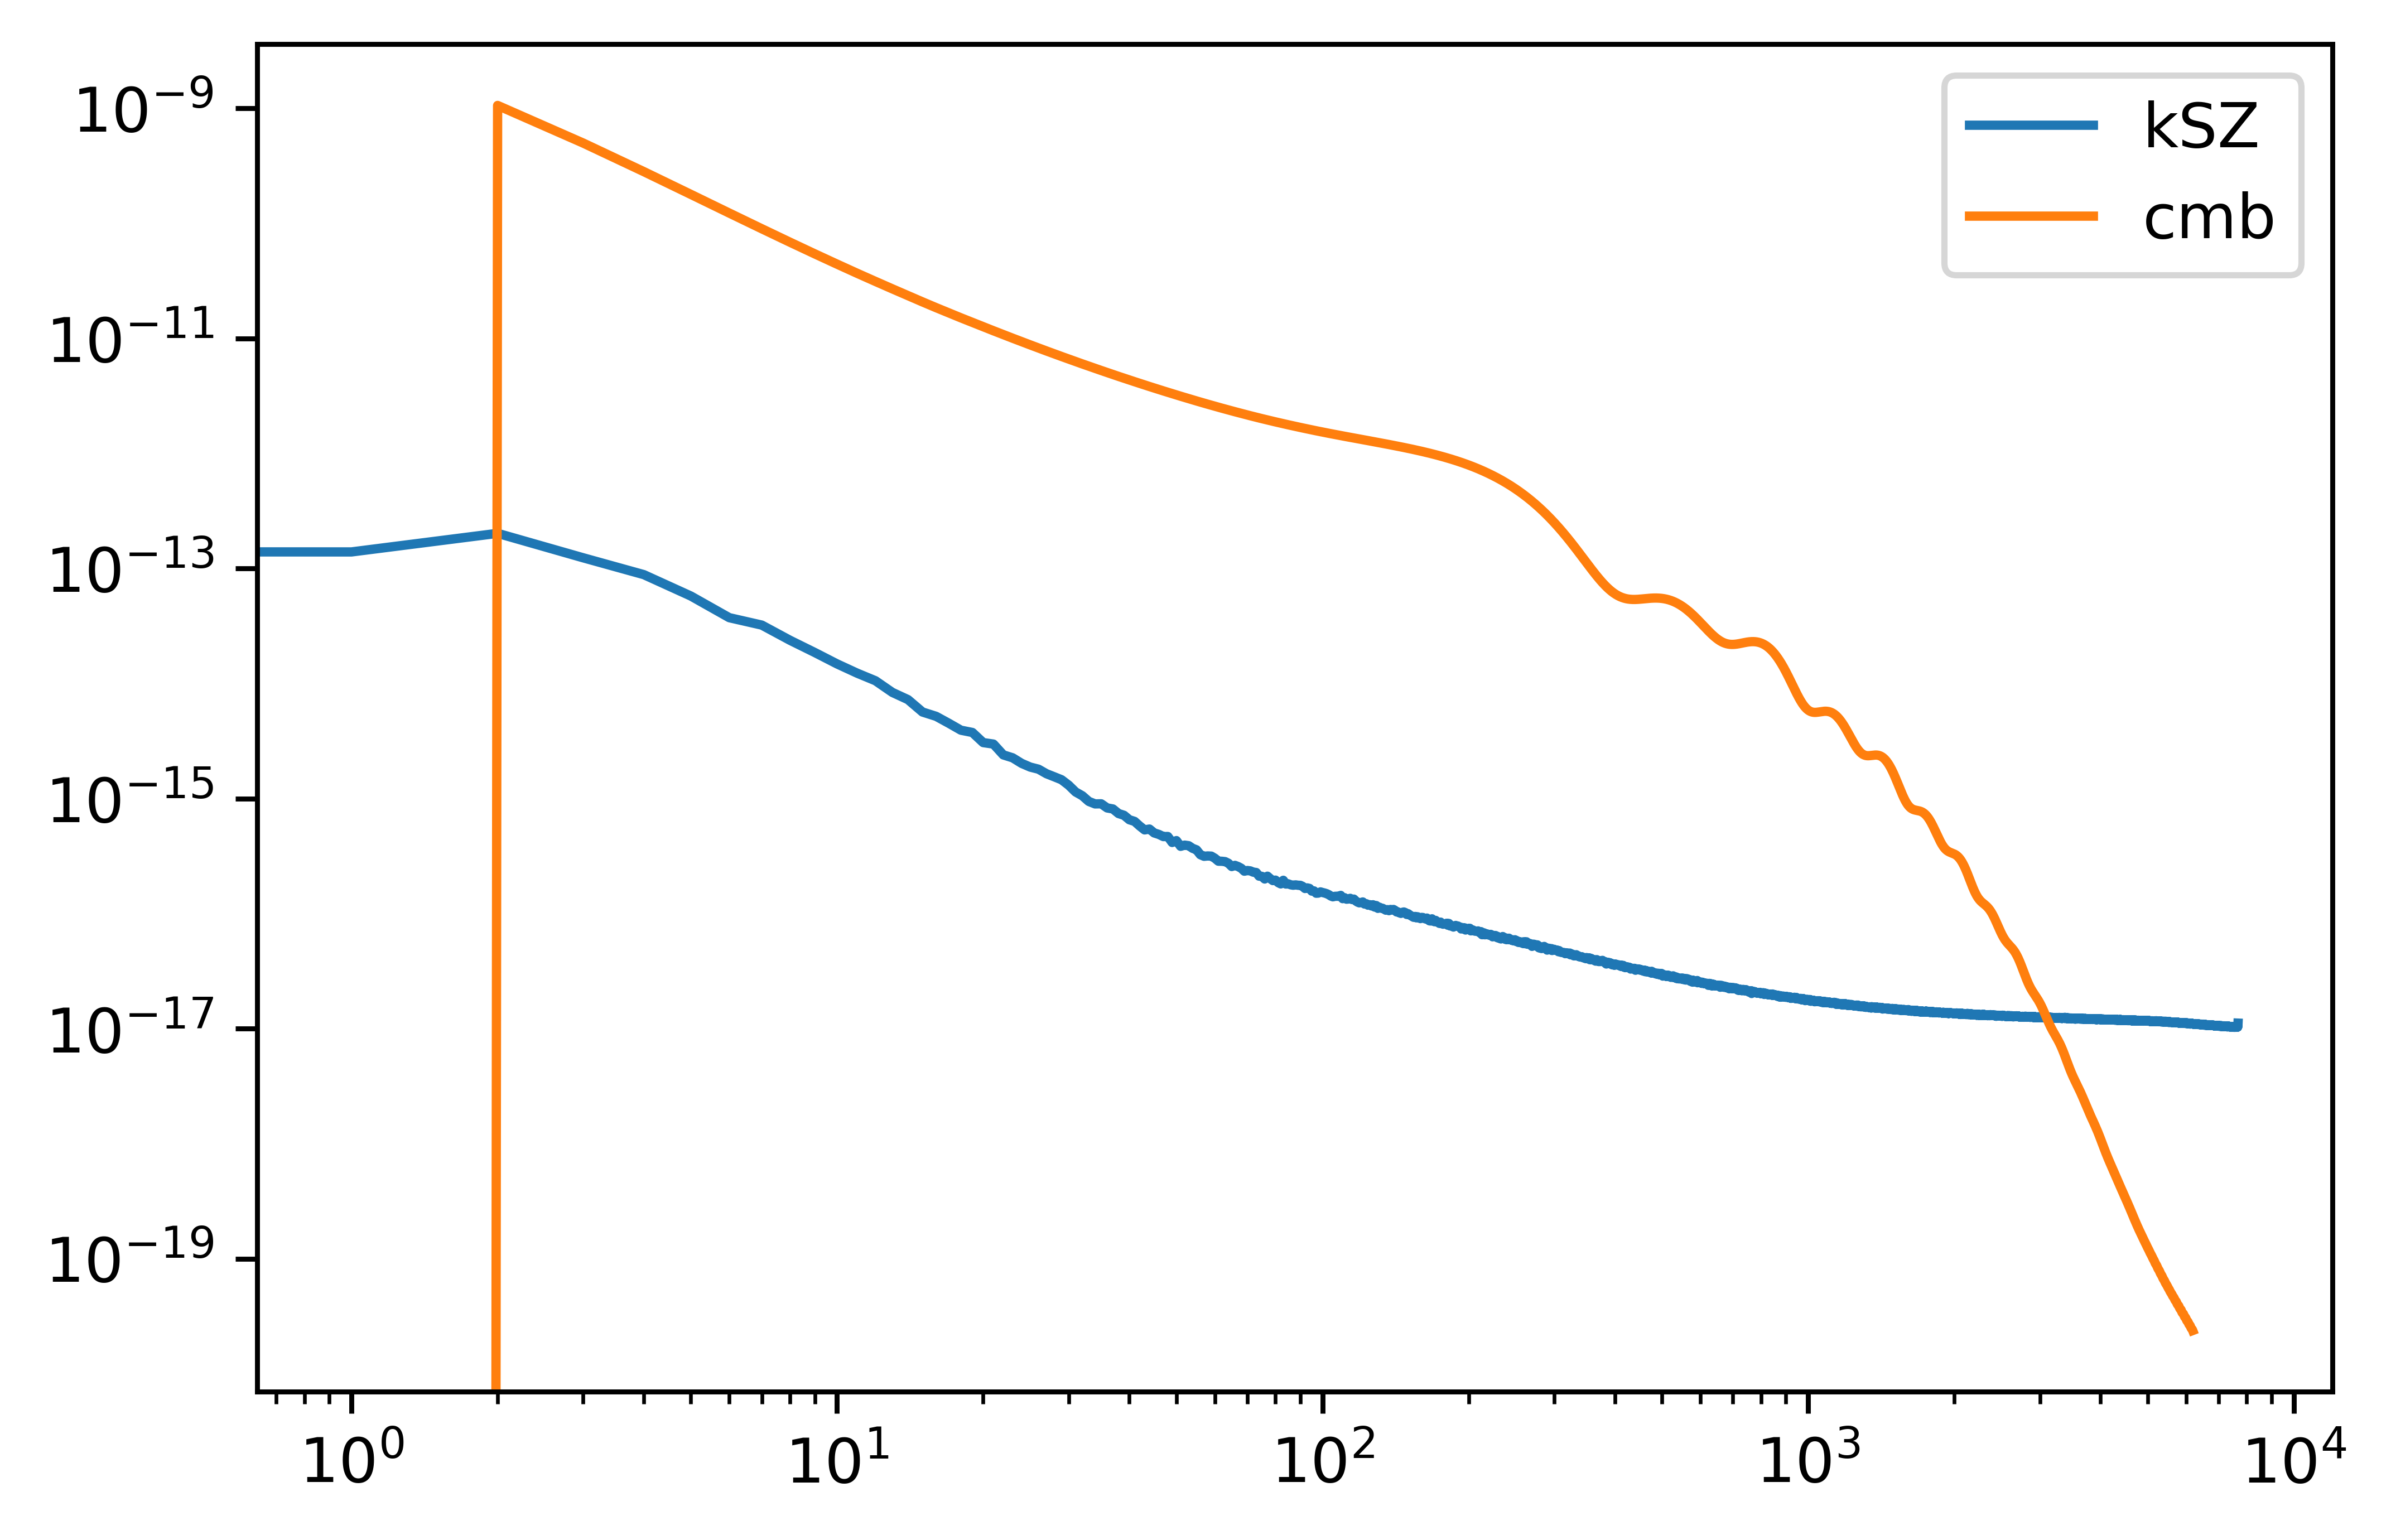

In [4]:
plt.figure(dpi=800)
plt.loglog(kSZ_PS);
plt.loglog(CMB_camb);
plt.legend(['kSZ','cmb']);

In [6]:
fakekSZ = hp.synfast(kSZ_PS,nside=NSIDE)
fakeCMB = hp.synfast(CMB_camb,nside=NSIDE)

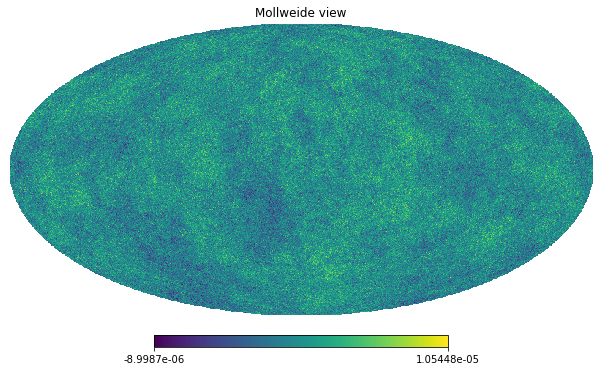

In [7]:
hp.mollview(fakekSZ)

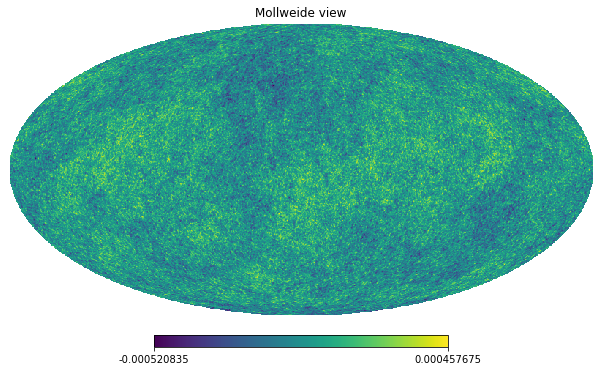

In [8]:
hp.mollview(fakeCMB)

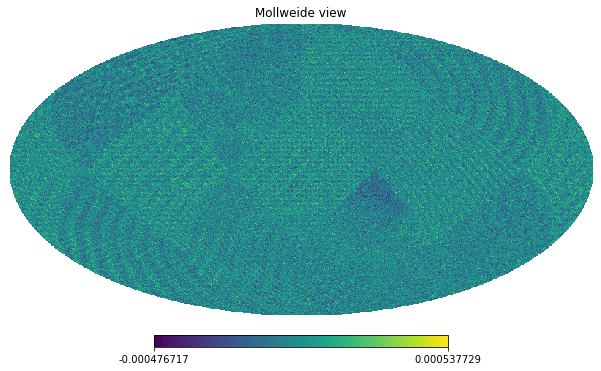

In [9]:
hp.mollview(fakeCMB,nest=True)

## Generate squares of data for ML

In [5]:
NSIDE=512

In [21]:
genMaps = 10
nsideDivs = 16
angularDivs = 12*nsideDivs**2
npix = 12*NSIDE**2
block_size = npix//angularDivs

CMB_squares = np.zeros((genMaps,angularDivs,block_size))
kSZ_squares = np.zeros((genMaps,angularDivs,block_size))

totalPix = 0

for i in range(genMaps):
    fakekSZ = hp.reorder(hp.synfast(kSZ_PS,nside=NSIDE),r2n=True)
    fakeCMB = hp.reorder(hp.synfast(CMB_camb,nside=NSIDE),r2n=True)
    for j in range(angularDivs):
        pixels = np.arange(j*block_size,(j+1)*block_size)
        kSZ_squares[i,j,:] = fakekSZ[pixels]
        CMB_squares[i,j,:] = fakeCMB[pixels]
        #fakeCMB[pixels]=j

In [22]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [23]:
x_raw = (kSZ_squares+CMB_squares).reshape(-1, block_size)
y_raw = kSZ_squares.reshape(-1, block_size)

numSets = genMaps*angularDivs
x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-numSets//20])
y_train, y_test = np.split(y_raw, indices_or_sections=[numSets-numSets//20])

In [24]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.shuffle(200)
dset_test = dset_test.batch(20)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(200)
dset_train = dset_train.batch(20)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

dset_train = dset_train.prefetch(buffer_size=AUTOTUNE)
dset_test = dset_test.prefetch(buffer_size=AUTOTUNE)

In [26]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [27]:
block_size

1024

In [28]:
# Create a `Sequential` model and add a Dense layer as the first layer.
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(block_size,)))
model.add(tf.keras.layers.Dense(block_size, activation='sigmoid'))
model.add(tf.keras.layers.Dense(2*block_size,activation="sigmoid"))
model.add(tf.keras.layers.Dense(block_size,activation="linear"))
model.output_shape


(None, 1024)

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(optimizer=opt,
              loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                #loss="MSE",
              metrics=[r_square]
)

In [30]:
initial_epochs = 100
history = model.fit(
    dset_train,
    epochs=initial_epochs,
    validation_data = dset_test
)

Epoch 1/100
1460/1460 [==============================] - 5s 4ms/step - loss: 4.7772e-04 - r_square: -103038504.0000 - val_loss: 9.6769e-12 - val_r_square: -1.0057
Epoch 2/100
1460/1460 [==============================] - 5s 4ms/step - loss: 9.7387e-12 - r_square: -1.0224 - val_loss: 9.8923e-12 - val_r_square: -1.0488
Epoch 3/100
1460/1460 [==============================] - 5s 3ms/step - loss: 9.8399e-12 - r_square: -1.0438 - val_loss: 1.0240e-11 - val_r_square: -1.1220
Epoch 4/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.0082e-11 - r_square: -1.0934 - val_loss: 1.0387e-11 - val_r_square: -1.1501
Epoch 5/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.0493e-11 - r_square: -1.1792 - val_loss: 1.1436e-11 - val_r_square: -1.3674
Epoch 6/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.1046e-11 - r_square: -1.2947 - val_loss: 1.3091e-11 - val_r_square: -1.7118
Epoch 7/100
1460/1460 [==============================] - 5s 4m

1460/1460 [==============================] - 6s 4ms/step - loss: 1.1102e-11 - r_square: -1.3050 - val_loss: 1.5509e-11 - val_r_square: -2.2157
Epoch 54/100
1460/1460 [==============================] - 6s 4ms/step - loss: 1.2549e-11 - r_square: -1.6068 - val_loss: 1.3463e-11 - val_r_square: -1.7875
Epoch 55/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.0256e-11 - r_square: -1.1302 - val_loss: 1.2132e-11 - val_r_square: -1.5105
Epoch 56/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.1530e-11 - r_square: -1.3953 - val_loss: 1.1571e-11 - val_r_square: -1.3987
Epoch 57/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.0040e-11 - r_square: -1.0850 - val_loss: 1.0491e-11 - val_r_square: -1.1732
Epoch 58/100
1460/1460 [==============================] - 5s 4ms/step - loss: 1.0146e-11 - r_square: -1.1066 - val_loss: 1.1843e-11 - val_r_square: -1.4535
Epoch 59/100
1460/1460 [==============================] - 5s 4ms/step - loss:

KeyboardInterrupt: 